In [ ]:
## DESCARGAMOS LOS TWEETS EN FORMATO CSV POR MEDIO DEL SIGUIENTE LINK
## https://www.vicinitas.io/free-tools/download-user-tweets?tracker=santipenap
## https://www.vicinitas.io/free-tools/download-user-tweets?tracker=efrainalegre
## ..

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

In [ ]:

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')


In [ ]:

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Obtenemos los datos mediante un csv descargado
tweets_santip = pd.read_csv(r"SantiPenap_user_tweets_f.csv", delimiter=';', engine='python',encoding = "ISO-8859-1")
tweets_efrainaleg = pd.read_csv(r"EfrainAlegre_user_tweets_f.csv", delimiter=';', engine='python',encoding = "ISO-8859-1")
tweets_payocub = pd.read_csv(r"ParaguayoCubas_user_tweets_f.csv", delimiter=';', engine='python',encoding = "ISO-8859-1")
tweets_eucliacev = pd.read_csv(r"euclides2023_user_tweets_f.csv", delimiter=';', engine='python',encoding = "ISO-8859-1")

In [ ]:
# Miramos las cantidades de tweets a analizar por candidatos
print('Número de tweets de Santi Peña: ' + str(tweets_santip.shape[0]))
print('Número de tweets de Efrain Alegre: ' + str(tweets_efrainaleg.shape[0]))
print('Número de tweets de Payo Cubas: ' + str(tweets_payocub.shape[0]))
print('Número de tweets de Euclides Acevedo: ' + str(tweets_eucliacev.shape[0]))

Número de tweets de Santi Peña: 3198
Número de tweets de Efrain Alegre: 3199
Número de tweets de Payo Cubas: 3196
Número de tweets de Euclides Acevedo: 1631


In [ ]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_santip, tweets_efrainaleg, tweets_payocub, tweets_eucliacev], ignore_index=True)

In [ ]:
# Miramos el dataframe
tweets.head(3)

,Tweet Id,Text,Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,ï»¿Tweet Id
0,1340.0,"""Fuerza che memby, ñaganata"" https://t.co/GXpM...",Santiago Peña,2017-10-14T02:34:09.000Z,Sat Oct 14 02:34:09 +0000 2017,436,102,tl,"<a href=""http://twitter.com/download/android"" ...",Tweet,NaN,0,0,photo,NaN
1,827.0,"""Nadie puede dudar que @AllianaPedro y yo somo...",Santiago Peña,2022-05-09T01:06:30.000Z,Mon May 09 01:06:30 +0000 2022,121,26,es,"<a href=""http://twitter.com/download/iphone"" r...",Reply,NaN,2,1,None,NaN
2,1686.0,"""Ñamba'apóta oñondive Santi"" \n\n#OñondiveJaja...",Santiago Peña,2017-11-26T00:54:15.000Z,Sun Nov 26 00:54:15 +0000 2017,222,80,es,"<a href=""http://twitter.com/download/android"" ...",Tweet,NaN,2,0,photo,NaN


In [ ]:
# Se seleccionan y renombran las columnas de interés
tweets = tweets[['Name', 'Created At', 'Tweet Id', 'Text','Retweets','Favorites','Media Type']]
tweets.columns = ['autor', 'fecha', 'id', 'texto','retweets','favs','media_type']

In [ ]:
tweets

,autor,fecha,id,texto,retweets,favs,media_type
0,Santiago Peña,Sat Oct 14 02:34:09 +0000 2017,1340.0,"""Fuerza che memby, ñaganata"" https://t.co/GXpM...",102,436,photo
1,Santiago Peña,Mon May 09 01:06:30 +0000 2022,827.0,"""Nadie puede dudar que @AllianaPedro y yo somo...",26,121,None
2,Santiago Peña,Sun Nov 26 00:54:15 +0000 2017,1686.0,"""Ñamba'apóta oñondive Santi"" \n\n#OñondiveJaja...",80,222,photo
3,Santiago Peña,Sat Oct 21 02:18:52 +0000 2017,1350.0,"""Pastoreo ojapóta ndehegui Presidente de la Re...",73,274,photo
4,Santiago Peña,Wed Nov 29 08:01:20 +0000 2017,3088.0,#Agenda Acompañanos camino a la gran victoria ...,79,148,photo
...,...,...,...,...,...,...,...
11219,Euclides Acevedo,Wed Apr 29 00:04:30 +0000 2020,NaN,ð´EN VIVO: @C9NParaguay https://t.co/JWijwUedr2,43,469,photo
11220,Euclides Acevedo,Sun May 24 13:25:52 +0000 2020,NaN,ð´EN VIVO: @sntcanal9\nhttps://t.co/OUEPaiQb...,19,138,photo
11221,Euclides Acevedo,Wed Apr 22 15:21:17 +0000 2020,NaN,"ð´EN VIVO: Compartiendo con @EugeCasielles, ...",9,124,photo
11222,Euclides Acevedo,Sun Apr 19 23:22:45 +0000 2020,NaN,ð´EN VIVO: Telefuturo\n#Covid19\n#QuedateEnC...,45,585,photo


In [ ]:
# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto,retweets,favs,media_type
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,"""Fuerza che memby, ñaganata"" https://t.co/GXpM...",102,436,photo
1,Santiago Peña,2022-05-09 01:06:30+00:00,827.0,"""Nadie puede dudar que @AllianaPedro y yo somo...",26,121,None
2,Santiago Peña,2017-11-26 00:54:15+00:00,1686.0,"""Ñamba'apóta oñondive Santi"" \n\n#OñondiveJaja...",80,222,photo


**Distribución temporal de los tweets**


Dado que cada usuario puede haber iniciado su actividad en Twitter en diferente momento, es interesante explorar si los tweets recuperados solapan en el tiempo.

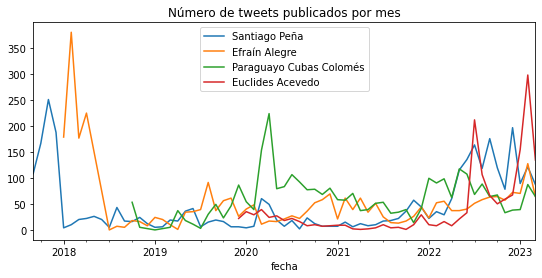

In [ ]:
# Distribución temporal de los tweets
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

**Limpieza y Tokenización**


El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

In [ ]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\ð\\µ\\¾\\\\»]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')   
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    
    return(nuevo_texto)

In [ ]:
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""Fuerza che memby, ñaganata"" https://t.co/GXpM...","[fuerza, che, memby, ñaganata]"
1,"""Nadie puede dudar que @AllianaPedro y yo somo...","[nadie, puede, dudar, que, allianapedro, yo, s..."
2,"""Ñamba'apóta oñondive Santi"" \n\n#OñondiveJaja...","[ñamba, apóta, oñondive, santi, oñondivejajapo..."
3,"""Pastoreo ojapóta ndehegui Presidente de la Re...","[pastoreo, ojapóta, ndehegui, presidente, de, ..."
4,#Agenda Acompañanos camino a la gran victoria ...,"[agenda, acompañanos, camino, la, gran, victor..."


In [ ]:
tweets

,autor,fecha,id,texto,retweets,favs,media_type,texto_tokenizado
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,"""Fuerza che memby, ñaganata"" https://t.co/GXpM...",102,436,photo,"[fuerza, che, memby, ñaganata]"
1,Santiago Peña,2022-05-09 01:06:30+00:00,827.0,"""Nadie puede dudar que @AllianaPedro y yo somo...",26,121,None,"[nadie, puede, dudar, que, allianapedro, yo, s..."
2,Santiago Peña,2017-11-26 00:54:15+00:00,1686.0,"""Ñamba'apóta oñondive Santi"" \n\n#OñondiveJaja...",80,222,photo,"[ñamba, apóta, oñondive, santi, oñondivejajapo..."
3,Santiago Peña,2017-10-21 02:18:52+00:00,1350.0,"""Pastoreo ojapóta ndehegui Presidente de la Re...",73,274,photo,"[pastoreo, ojapóta, ndehegui, presidente, de, ..."
4,Santiago Peña,2017-11-29 08:01:20+00:00,3088.0,#Agenda Acompañanos camino a la gran victoria ...,79,148,photo,"[agenda, acompañanos, camino, la, gran, victor..."
...,...,...,...,...,...,...,...,...
11219,Euclides Acevedo,2020-04-29 00:04:30+00:00,NaN,ð´EN VIVO: @C9NParaguay https://t.co/JWijwUedr2,43,469,photo,"[´en, vivo, nparaguay]"
11220,Euclides Acevedo,2020-05-24 13:25:52+00:00,NaN,ð´EN VIVO: @sntcanal9\nhttps://t.co/OUEPaiQb...,19,138,photo,"[´en, vivo, sntcanal]"
11221,Euclides Acevedo,2020-04-22 15:21:17+00:00,NaN,"ð´EN VIVO: Compartiendo con @EugeCasielles, ...",9,124,photo,"[´en, vivo, compartiendo, con, eugecasielles,..."
11222,Euclides Acevedo,2020-04-19 23:22:45+00:00,NaN,ð´EN VIVO: Telefuturo\n#Covid19\n#QuedateEnC...,45,585,photo,"[´en, vivo, telefuturo, covid, quedateencasapy]"


**Análisis exploratorio**


A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos..

In [ ]:
# Totales por cada autor
# ==============================================================================
print('--------------------------')
print('RTs totales por autor')
print('--------------------------')
tweets.groupby(by='autor')['retweets'].sum()

--------------------------
RTs totales por autor
--------------------------


autor
Efraín Alegre               72883
Euclides Acevedo            47988
Paraguayo Cubas Colomés     79046
Santiago Peña              154359
Name: retweets, dtype: int64

In [ ]:
# Totales por cada autor
# ==============================================================================
print('--------------------------')
print('Favs totales por autor')
print('--------------------------')
tweets.groupby(by='autor')['favs'].sum()

--------------------------
Favs totales por autor
--------------------------


autor
Efraín Alegre              264717
Euclides Acevedo           307382
Paraguayo Cubas Colomés    311489
Santiago Peña              848975
Name: favs, dtype: int64

In [ ]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,retweets,favs,media_type,token
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,fuerza
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,che
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,memby


In [ ]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
Efraín Alegre              91893
Euclides Acevedo           35726
Paraguayo Cubas Colomés    39885
Santiago Peña              70520
Name: token, dtype: int64

In [ ]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
Efraín Alegre              9629
Euclides Acevedo           6384
Paraguayo Cubas Colomés    9657
Santiago Peña              7821
Name: token, dtype: int64

In [ ]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
Efraín Alegre,28.725539,11.011181
Paraguayo Cubas Colomés,12.479662,10.186273
Santiago Peña,22.051282,10.124338


In [ ]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                                              
Efraín Alegre           2363             Efraín Alegre    de   4992
                        5165             Efraín Alegre    la   4691
                        7286             Efraín Alegre   que   2887
                        3095             Efraín Alegre    el   2872
                        3238             Efraín Alegre    en   2276
Euclides Acevedo        11062         Euclides Acevedo    de   2049
                        12766         Euclides Acevedo    la   1848
                        11492         Euclides Acevedo    el   1197
                        11557         Euclides Acevedo    en    857
                        14238         Euclides Acevedo   que    696
Paraguayo Cubas Colomés 18341  Paraguayo Cubas Colomés    de   1501
                        20978  Paraguayo Cubas Colomés    la   1217
                        19045  Paraguayo Cubas Colomés    en   1105
                        18947  Paraguayo Cubas Colomés    el    896
                        22066  Paraguayo Cubas Colomés    no    508
Santiago Peña           27454            Santiago Peña    de   3940
                        29698            Santiago Peña    la   2548
                        28010            Santiago Peña    el   2176
                        31424            Santiago Peña   que   2004
                        28132            Santiago Peña    en   1769

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [ ]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('spanish'))
print(stop_words[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [ ]:
stop_words.extend(("paraguay","gran","si", "santipenap", "payo","paraguayos","euclidespresidente","rt","mil"))

In [ ]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

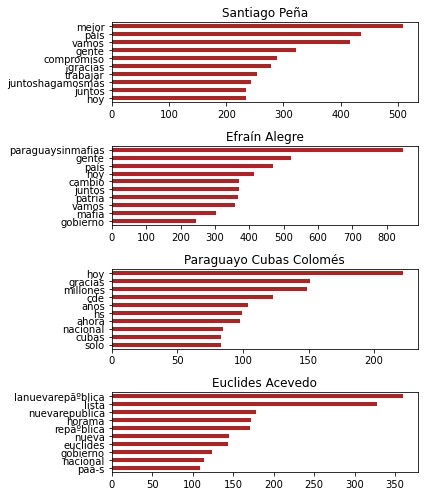

In [ ]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

In [ ]:
tweets_tidy[tweets_tidy["autor"] == 'Euclides Acevedo']

,autor,fecha,id,retweets,favs,media_type,token
9593,Euclides Acevedo,2023-02-28 14:01:41+00:00,NaN,5,27,photo,â¼ï¸salud
9593,Euclides Acevedo,2023-02-28 14:01:41+00:00,NaN,5,27,photo,fernando
9593,Euclides Acevedo,2023-02-28 14:01:41+00:00,NaN,5,27,photo,moraâ¼ï¸
9593,Euclides Acevedo,2023-02-28 14:01:41+00:00,NaN,5,27,photo,abrazo
9593,Euclides Acevedo,2023-02-28 14:01:41+00:00,NaN,5,27,photo,fraterno
...,...,...,...,...,...,...,...
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,ª
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,raãºltuma
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,diputado
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,lanuevarepãºblica


**Correlación entre autores**

Una forma de cuantificar la similitud entre los perfiles de dos usuarios de Twitter es calculando la correlación en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tenderán a utilizar las mismas palabras y con frecuencias similares. La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlación se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [ ]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [ ]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,Efraín Alegre,Euclides Acevedo,Paraguayo Cubas Colomés,Santiago Peña
Efraín Alegre,1.000000,0.522311,0.532237,0.702676
Euclides Acevedo,0.522311,1.000000,0.502643,0.558652
Paraguayo Cubas Colomés,0.532237,0.502643,1.000000,0.497720
Santiago Peña,0.702676,0.558652,0.497720,1.000000


In [ ]:
tweets_pivot

,Efraín Alegre,Euclides Acevedo,Paraguayo Cubas Colomés,Santiago Peña
token,,,,
aa,3.0,NaN,NaN,NaN
aaa,NaN,NaN,1.0,NaN
aalevera,NaN,2.0,NaN,NaN
aam,NaN,NaN,NaN,3.0
aamradio,1.0,NaN,NaN,NaN
...,...,...,...,...
único,25.0,NaN,14.0,3.0
únicos,NaN,NaN,NaN,1.0
útil,1.0,NaN,3.0,NaN


In [ ]:
tweets_pivot.head(3)

,Efraín Alegre,Euclides Acevedo,Paraguayo Cubas Colomés,Santiago Peña
token,,,,
aa,3.0,NaN,NaN,NaN
aaa,NaN,NaN,1.0,NaN
aalevera,NaN,2.0,NaN,NaN


In [ ]:
# Se seleccionan y renombran las columnas de interés
tweets_pivot = tweets_pivot[['Efraín Alegre', 'Euclides Acevedo', 'Paraguayo Cubas Colomés', 'Santiago Peña']]
tweets_pivot.columns = ['efrain_alegre', 'euclides_acevedo', 'paraguayo_cubas', 'santiago_peña']

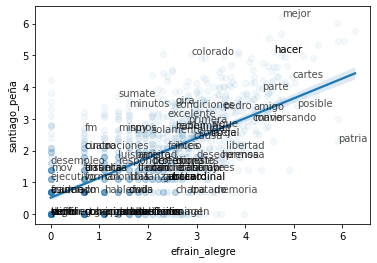

In [ ]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.efrain_alegre),
    y  = np.log(temp.santiago_peña),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.efrain_alegre[i]), np.log(temp.santiago_peña[i])),
        alpha = 0.7
    )

In [ ]:
# Número de palabras comunes
# ==============================================================================
palabras_efrain = set(tweets_tidy[tweets_tidy.autor == 'Efraín Alegre']['token'])
palabras_santi = set(tweets_tidy[tweets_tidy.autor == 'Santiago Peña']['token'])
palabras_euclides = set(tweets_tidy[tweets_tidy.autor == 'Euclides Acevedo']['token'])
palabras_payo = set(tweets_tidy[tweets_tidy.autor == 'Paraguayo Cubas Colomés']['token'])

print(f"Palabras comunes entre Efrain y Santi: {len(palabras_efrain.intersection(palabras_santi))}")

print(f"Palabras comunes entre Efrain y Euclides: {len(palabras_efrain.intersection(palabras_euclides))}")

print(f"Palabras comunes entre Efrain y Payo: {len(palabras_efrain.intersection(palabras_payo))}")

print(f"Palabras comunes entre Santi y Euclides: {len(palabras_santi.intersection(palabras_euclides))}")

print(f"Palabras comunes entre Santi y Payo: {len(palabras_santi.intersection(palabras_payo))}")

print(f"Palabras comunes entre Euclides y Payo: {len(palabras_euclides.intersection(palabras_payo))}")

Palabras comunes entre Efrain y Santi: 3684
Palabras comunes entre Efrain y Euclides: 2425
Palabras comunes entre Efrain y Payo: 3435
Palabras comunes entre Santi y Euclides: 2117
Palabras comunes entre Santi y Payo: 2749
Palabras comunes entre Euclides y Payo: 1959


**Análisis de sentimientos**



Una forma de analizar el sentimiento de un de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman. Esta no es la única forma de abordar el análisis de sentimientos, pero consigue un buen equilibrio entre complejidad y resultados.

Para llevar a cabo esta aproximación es necesario disponer de un diccionario en el que se asocie a cada palabra un sentimiento o nivel de sentimiento. A estos diccionarios también se les conoce como sentiment lexicon. Uno de los más utilizados es:

AFINN: en él, se asigna a cada palabra un valor entre -5 y 5, siendo -5 el máximo de negatividad y +5 el máximo de positividad. Se puede acceder al diccionario a través del repositorio:
https://raw.githubusercontent.com/jboscomendoza/rpubs/master/sentimientos_afinn/lexico_afinn.en.es.csv

In [ ]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_csv(r'https://raw.githubusercontent.com/jboscomendoza/rpubs/master/sentimientos_afinn/lexico_afinn.en.es.csv', engine='python',encoding = "ISO-8859-1")
lexicon.head()

,Palabra,Puntuacion,Word
0,a bordo,1,aboard
1,abandona,-2,abandons
2,abandonado,-2,abandoned
3,abandonar,-2,abandon
4,abatido,-2,dejected


In [ ]:
tweets_tidy

,autor,fecha,id,retweets,favs,media_type,token
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,fuerza
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,che
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,memby
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,ñaganata
1,Santiago Peña,2022-05-09 01:06:30+00:00,827.0,26,121,None,nadie
...,...,...,...,...,...,...,...
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,ª
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,raãºltuma
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,diputado
11223,Euclides Acevedo,2023-03-05 12:10:59+00:00,NaN,9,42,video,lanuevarepãºblica


In [ ]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "Palabra",
                            how      = "inner"
                      )


In [ ]:
tweets_sentimientos

,autor,fecha,id,retweets,favs,media_type,token,Palabra,Puntuacion,Word
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,fuerza,fuerza,2,strength
1,Santiago Peña,2017-10-24 14:20:43+00:00,2663.0,45,203,video,fuerza,fuerza,2,strength
2,Santiago Peña,2017-10-07 23:15:38+00:00,1332.0,58,243,photo,fuerza,fuerza,2,strength
3,Santiago Peña,2017-11-25 15:36:08+00:00,1305.0,135,368,photo,fuerza,fuerza,2,strength
4,Santiago Peña,2022-09-14 21:38:11+00:00,3168.0,34,239,photo,fuerza,fuerza,2,strength
...,...,...,...,...,...,...,...,...,...,...
14293,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,inseguro,-1,doubting
14294,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,inseguro,-2,insecure
14295,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,inseguro,-1,unsure
14296,Euclides Acevedo,2021-12-02 03:05:36+00:00,NaN,2,18,None,angustia,angustia,-3,anguish


In [ ]:
tweets_sentimientos = tweets_sentimientos.drop(columns =['Palabra', 'Word'])

In [ ]:
tweets_sentimientos

,autor,fecha,id,retweets,favs,media_type,token,Puntuacion
0,Santiago Peña,2017-10-14 02:34:09+00:00,1340.0,102,436,photo,fuerza,2
1,Santiago Peña,2017-10-24 14:20:43+00:00,2663.0,45,203,video,fuerza,2
2,Santiago Peña,2017-10-07 23:15:38+00:00,1332.0,58,243,photo,fuerza,2
3,Santiago Peña,2017-11-25 15:36:08+00:00,1305.0,135,368,photo,fuerza,2
4,Santiago Peña,2022-09-14 21:38:11+00:00,3168.0,34,239,photo,fuerza,2
...,...,...,...,...,...,...,...,...
14293,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,-1
14294,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,-2
14295,Euclides Acevedo,2022-07-30 23:38:24+00:00,NaN,1,9,photo,inseguro,-1
14296,Euclides Acevedo,2021-12-02 03:05:36+00:00,NaN,2,18,None,angustia,-3


In [ ]:
# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos_sumatoria = tweets_sentimientos[["autor","fecha", "id", "Puntuacion"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()

In [ ]:
tweets_sentimientos_sumatoria

,autor,fecha,id,Puntuacion
0,Efraín Alegre,2018-01-08 01:46:27+00:00,1.0,4
1,Efraín Alegre,2018-01-08 12:46:35+00:00,2.0,0
2,Efraín Alegre,2018-01-08 20:08:29+00:00,4.0,2
3,Efraín Alegre,2018-01-09 12:26:20+00:00,7.0,4
4,Efraín Alegre,2018-01-09 12:36:04+00:00,8.0,-4
...,...,...,...,...
5525,Santiago Peña,2023-03-11 00:30:18+00:00,1210.0,9
5526,Santiago Peña,2023-03-11 15:09:58+00:00,1214.0,4
5527,Santiago Peña,2023-03-11 17:19:28+00:00,1215.0,4
5528,Santiago Peña,2023-03-11 23:46:25+00:00,1216.0,2


**Tweets positivos, negativos y neutros**

In [ ]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.Puntuacion > 0), 2)}")
    ## print(f"Neutros  : {round(100 * np.mean(df.Puntuacion == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.Puntuacion < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

Efraín Alegre
Positivos: 68.21
Negativos: 31.79
 
Euclides Acevedo
Positivos: 68.65
Negativos: 31.35
 
Paraguayo Cubas Colomés
Positivos: 39.41
Negativos: 60.59
 
Santiago Peña
Positivos: 79.12
Negativos: 20.88
 


Tres cantidatos  tienen un perfil muy similar. La gran mayoría de tweets son de tipo positivo. Este patrón es común en redes sociales, donde se suele participar mostrando aspectos o actividades positivas. Los usuarios no tienden a mostrar las cosas malas de sus vidas. El unico candidato que tiene alto porcentaje de tweets tipo negativo es Paraguayo Cubas, quien se identifica como un candidato controversial

**Evolución temporal**


A continuación, veremos cómo varía el sentimiento promedio de los tweets agrupados por intervalos de un mes para cada uno de los usuarios.

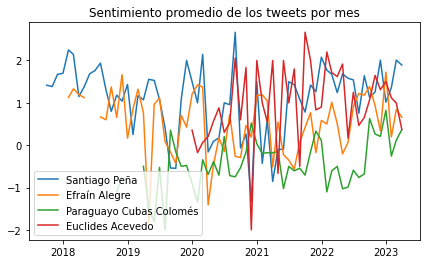

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['Puntuacion']].resample('1M').mean()
    ax.plot(df.index, df.Puntuacion, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();

**Bibliografía**

https://www.cienciadedatos.net/documentos/py25-text-mining-python.html

Text Mining with R: A Tidy Approach libro

Search Engines: Information Retrieval in Practice by Trevor Strohman, Donald Metzler, W. Bruce Croft

http://varianceexplained.org/r/trump-tweets/

http://programminghistorian.github.io/ph-submissions/lessons/published/basic-text-processing-in-r

http://cfss.uchicago.edu/fall2016/text01.html